Importing Dependencies

In [1]:
import tensorflow as tf
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths
import cv2 
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage, misc

Loading the TensorFlow BodyPix Model

In [2]:
bodypix_model = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

Function to perform Human-Body segmentation using BodyPix

In [3]:
def segment_BP(frame):
    result = bodypix_model.predict_single(frame)
    mask = result.get_mask(threshold=0.00).numpy().astype(np.uint8)
    masked_image = cv2.bitwise_and(frame, frame, mask=mask)
    return masked_image

Main

In [15]:
if __name__ == "__main__":
    file_path = r"D:\Users\koust\Downloads\human_interaction\competition_1_1_xvid.avi"
    cap = cv2.VideoCapture(file_path)
    ret, frame = cap.read()

    masked_image = segment_BP(frame)
    prvs = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    #Use any of the statistical measures as per requirements
    stdev = np.array([], dtype=np.float32)
    mean = np.array([], dtype=np.float32)
    variance= np.array([], dtype=np.float32)

    violence = np.array([], dtype=np.float32)
    count = 0

    while cap.isOpened(): 
        ret, frame = cap.read()
        if not ret:
            break
        
        masked_image = segment_BP(frame)
        next = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        stdev = np.append(stdev, np.std(mag, dtype=np.float32))
        mean = np.append(mean, np.mean(mag, dtype=np.float32))
        variance = np.append(variance, np.var(mag, dtype=np.float32))
        cv2.imshow('BodyPix', next)

        # Decision-making conditions for violence 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        if np.var(mag, dtype=np.float32) > 2.5*np.mean(mag, dtype=np.float32):
            violence = np.append(violence, 1)
        else :
            violence = np.append(violence, 0)
        count = count+1
        time = count*(1/30)
        if count>11:
                if np.logical_and(violence[count:count-6:-1],np.ones(5, dtype=np.float32), dtype=np.float32).all() == True:
                    print(f"Violence in frame {count}, at time:{time:7.3f}s")
        prvs=next

cap.release()
cv2.destroyAllWindows() 

Violence in frame 181, at time:  6.033s
Violence in frame 182, at time:  6.067s
Violence in frame 183, at time:  6.100s
Violence in frame 184, at time:  6.133s
Violence in frame 185, at time:  6.167s
Violence in frame 186, at time:  6.200s
Violence in frame 187, at time:  6.233s
Violence in frame 188, at time:  6.267s
Violence in frame 189, at time:  6.300s
Violence in frame 190, at time:  6.333s
Violence in frame 191, at time:  6.367s
Violence in frame 192, at time:  6.400s
Violence in frame 193, at time:  6.433s
Violence in frame 205, at time:  6.833s
Violence in frame 206, at time:  6.867s
Violence in frame 207, at time:  6.900s
Violence in frame 208, at time:  6.933s
Violence in frame 209, at time:  6.967s
Violence in frame 210, at time:  7.000s
Violence in frame 211, at time:  7.033s
Violence in frame 212, at time:  7.067s
Violence in frame 213, at time:  7.100s
Violence in frame 214, at time:  7.133s
Violence in frame 215, at time:  7.167s
Violence in frame 228, at time:  7.600s


Graphical Analysis

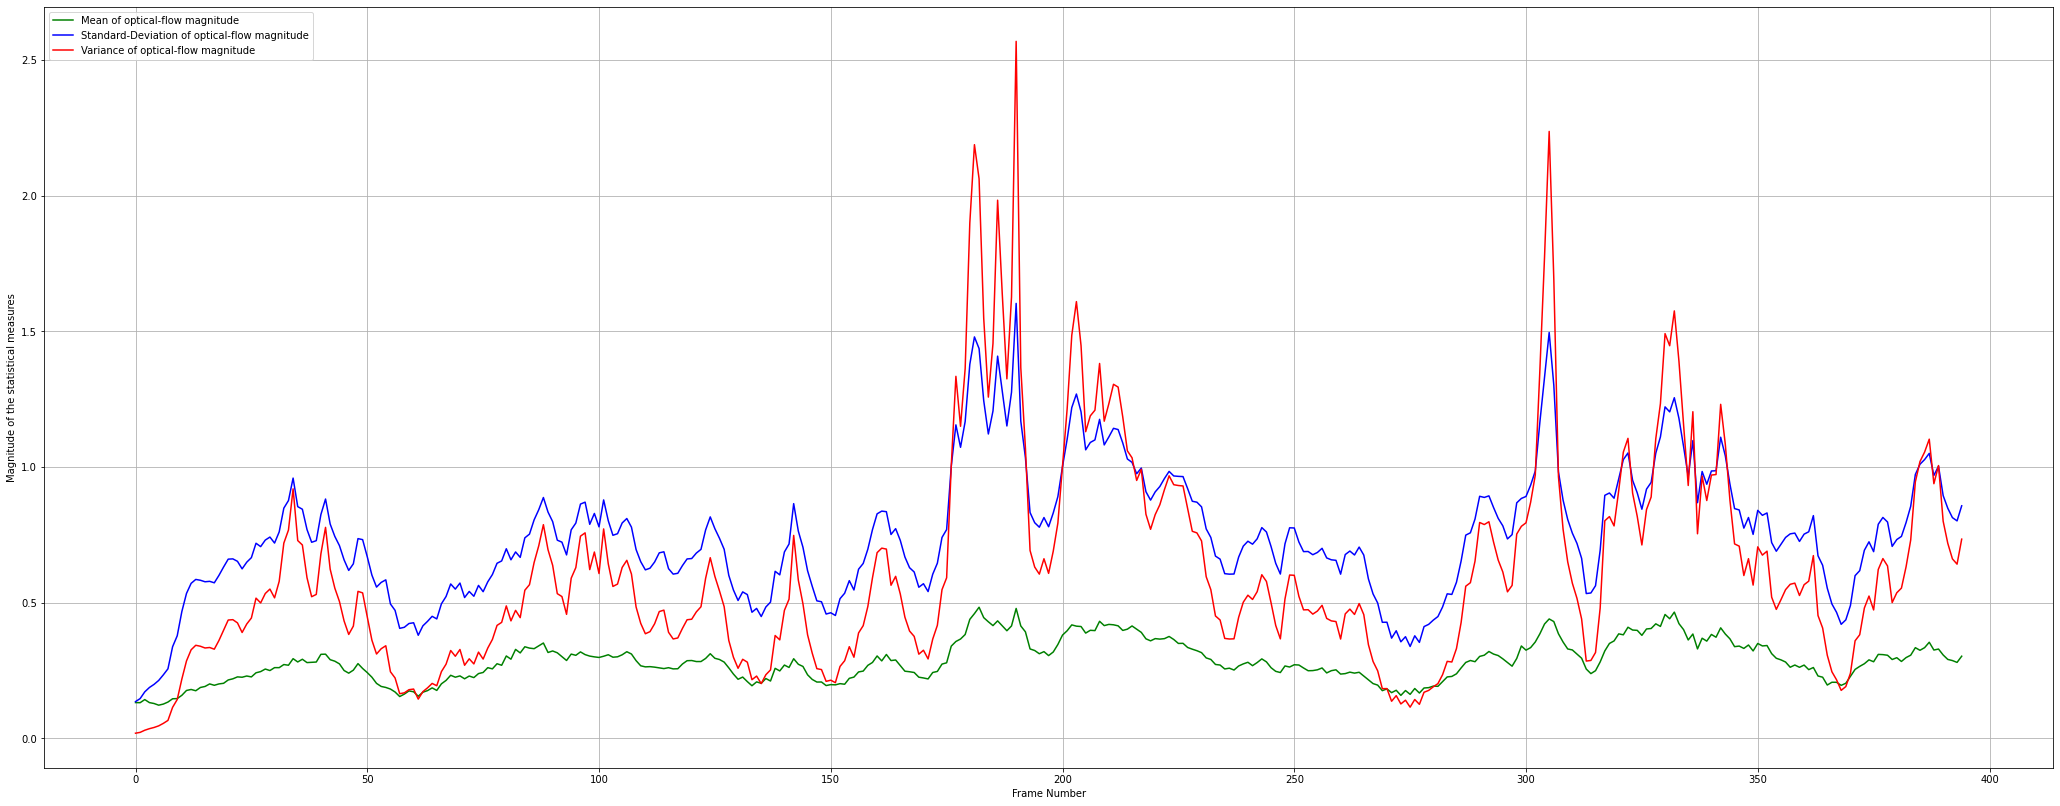

In [18]:
num_frames = np.arange(0,count,1)
plt.figure(figsize=(36, 14))
plt.plot(num_frames, mean, color='green', label='Mean of optical-flow magnitude')
plt.plot(num_frames, stdev, color='blue', label='Standard-Deviation of optical-flow magnitude')
plt.plot(num_frames, variance, color='red', label='Variance of optical-flow magnitude')
plt.legend(loc="upper left")
plt.xlabel("Frame Number")
plt.ylabel("Magnitude of the statistical measures")
plt.grid()
plt.show()